In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, KMeansSMOTE
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
file_path = '../data/processed/Juegorawg_limpio.csv'
df = pd.read_csv(file_path)
df.copy()

,slug,name,playtime,released,rating,rating_top,ratings_count,reviews_text_count,added,metacritic,suggestions_count,updated,reviews_count,release_year,main_genre,metacritic_category
0,hellpoint,Hellpoint,3,2020-07-30,2.76,3,51,2,2182,61.0,494,2024-11-26 14:58:37,54,2020,Indie,Media
1,anomaly-2,Anomaly 2,2,2013-05-14,2.90,4,62,0,1898,77.0,610,2024-10-07 11:59:32,62,2013,Strategy,Media
2,reverse-4,Resident Evil Re:Verse,1,2022-10-28,1.53,1,63,0,1662,78.0,456,2024-11-14 19:49:03,64,2022,Shooter,Media
3,x-morph-defense,X-Morph: Defense,3,2017-08-30,3.08,3,47,1,1657,75.0,702,2024-11-08 09:09:44,48,2017,Indie,Media
4,west-of-dead,West of Dead,1,2020-06-08,3.08,3,64,2,1634,68.0,456,2024-03-05 13:43:19,66,2020,Indie,Media
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3763,the-otterman-empire,The Otterman Empire,0,2020-07-02,0.00,0,0,0,0,76.5,333,2020-12-16 15:29:54,0,2020,Casual,Media
3764,jacks-or-better-video-poker,Jacks or Better - Video Poker,0,2020-06-12,0.00,0,0,0,0,76.5,0,2022-04-29 05:58:06,0,2020,Casual,Media
3765,jumanji-the-curse-returns,Jumanji: The Curse Returns,0,2021-09-01,0.00,0,0,0,0,76.0,251,2022-09-19 08:16:26,0,2021,Adventure,Media
3766,avocuddle,AvoCuddle,0,2019-07-12,0.00,0,0,0,0,73.0,400,2020-12-16 14:38:36,0,2019,Indie,Media


# Mejora en la imputación de metacritic con KNN

In [4]:
from sklearn.impute import KNNImputer

In [5]:
# Seleccionar columnas relevantes para la imputación
impute_cols = ['metacritic', 'playtime', 'ratings_count', 'release_year']
impute_df = df[impute_cols].copy()

# Crear y aplicar el imputador KNN
imputer = KNNImputer(n_neighbors=5)
imputed_values = imputer.fit_transform(impute_df)

# Reemplazar solo los valores faltantes de metacritic
metacritic_idx = impute_cols.index('metacritic')
mask = df['metacritic'].isna()
df.loc[mask, 'metacritic'] = imputed_values[mask, metacritic_idx]

# Verificar que no queden valores nulos
print(f"Valores nulos en metacritic después de imputación: {df['metacritic'].isna().sum()}")

Valores nulos en metacritic después de imputación: 0


# Transformación de Variables con Distribución Sesgada

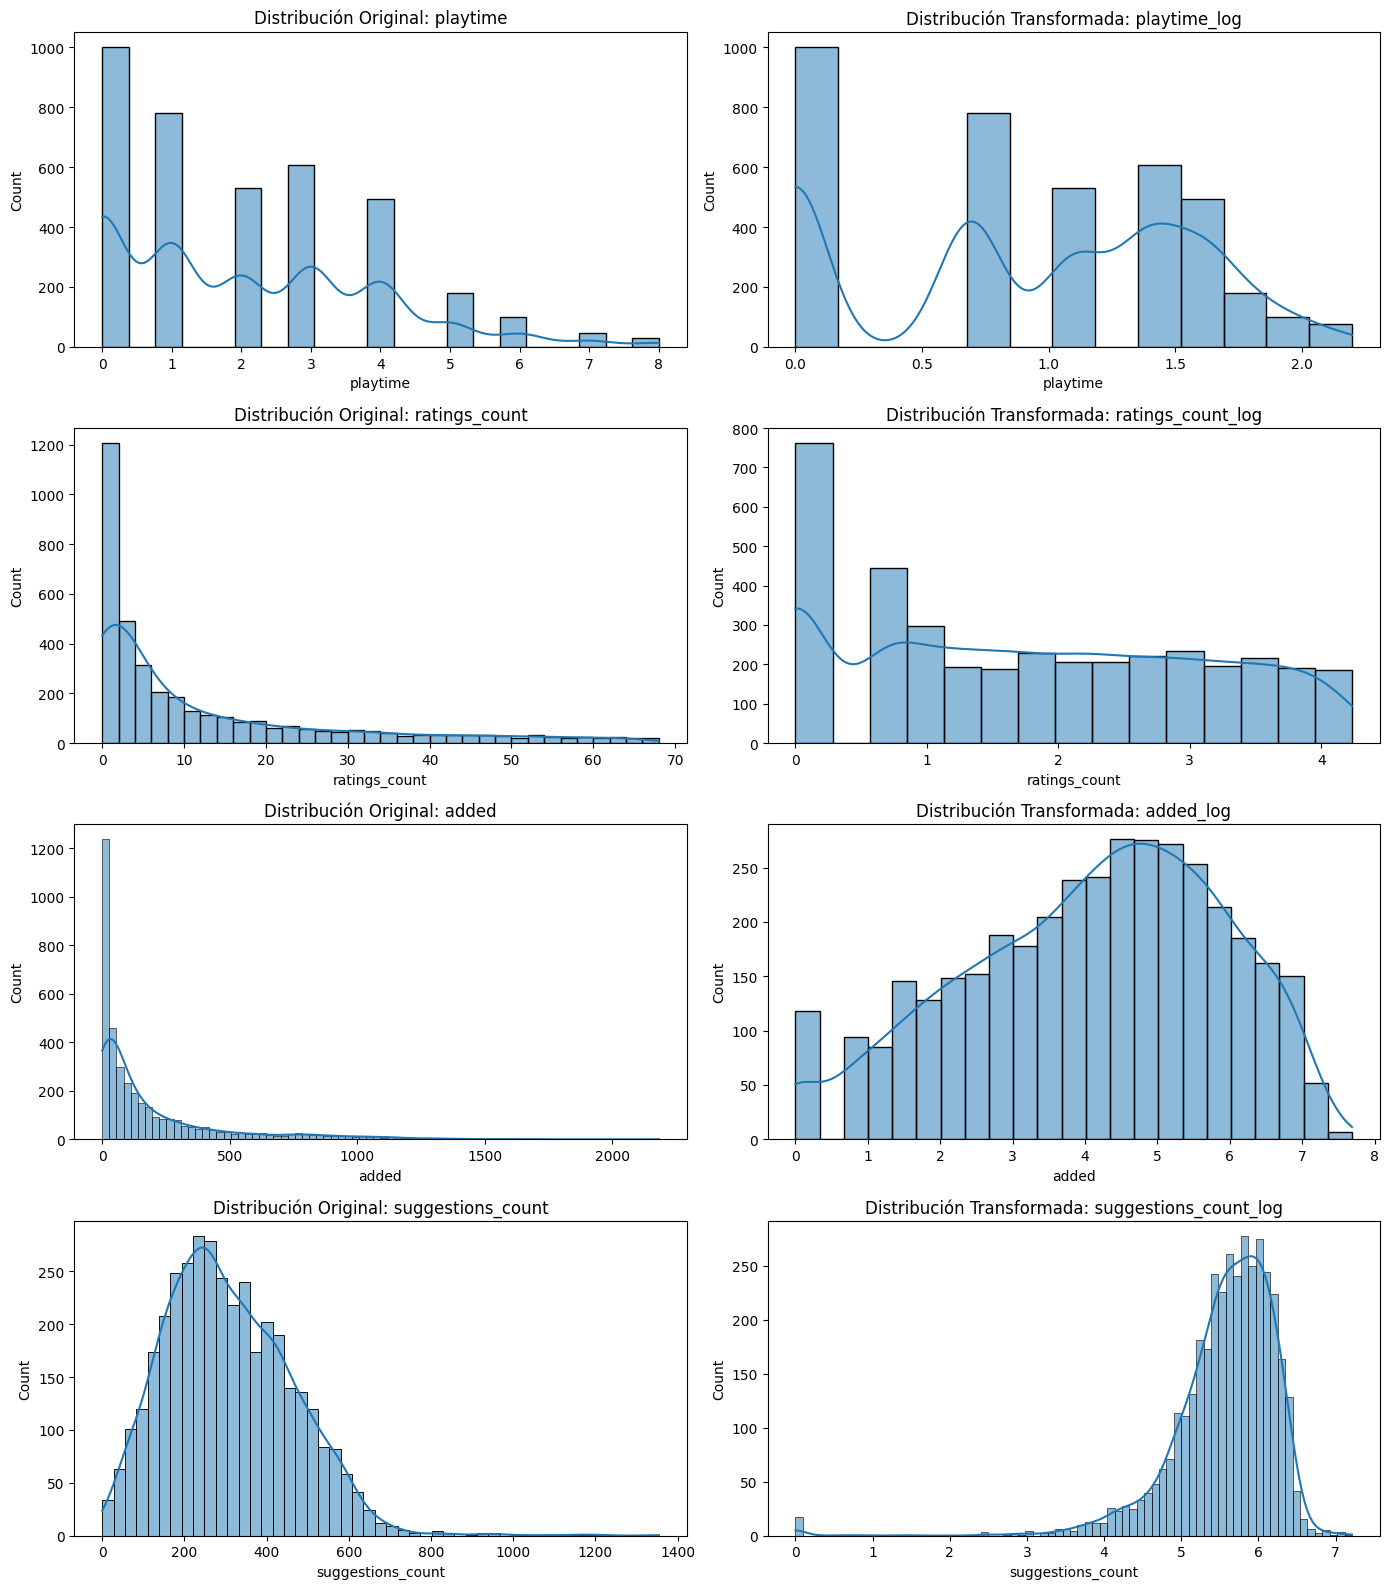

Transformaciones aplicadas: {'playtime': 'playtime_log', 'ratings_count': 'ratings_count_log', 'added': 'added_log', 'suggestions_count': 'suggestions_count_log'}


In [6]:
# Identificar variables numéricas con distribución sesgada
numeric_cols = ['playtime', 'ratings_count', 'added', 'suggestions_count']

# Visualizar distribuciones originales
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(14, 4*len(numeric_cols)))
transformations = {}

for i, col in enumerate(numeric_cols):
    # Distribución original
    sns.histplot(df[col], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribución Original: {col}')

    # Probar transformación logarítmica
    if df[col].min() >= 0:
        transformed = np.log1p(df[col])
        col_name = f'{col}_log'
    else:
        # Para valores negativos, usar otra transformación
        transformed = np.sign(df[col]) * np.log1p(np.abs(df[col]))
        col_name = f'{col}_signed_log'

    # Visualizar distribución transformada
    sns.histplot(transformed, kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'Distribución Transformada: {col_name}')

    # Guardar transformación
    df[col_name] = transformed
    transformations[col] = col_name

plt.tight_layout()
plt.show()

print("Transformaciones aplicadas:", transformations)

# Extracción de Características Temporales

In [7]:
df['released'] = pd.to_datetime(df['released'], errors='coerce')

# Extraer componentes de fecha
df['release_year'] = df['released'].dt.year
df['release_month'] = df['released'].dt.month
df['release_quarter'] = df['released'].dt.quarter
df['release_day_of_week'] = df['released'].dt.dayofweek

# Calcular tiempo desde lanzamiento (en días)
current_date = pd.Timestamp.now()
df['days_since_release'] = (current_date - df['released']).dt.days

# Crear variables categóricas de tiempo
df['is_recent'] = (df['days_since_release'] <= 365).astype(int)
df['release_era'] = pd.cut(
    df['release_year'],
    bins=[1990, 2000, 2010, 2015, 2020, 2025],
    labels=['90s', '00s', '10-15', '15-20', 'Recent']
)

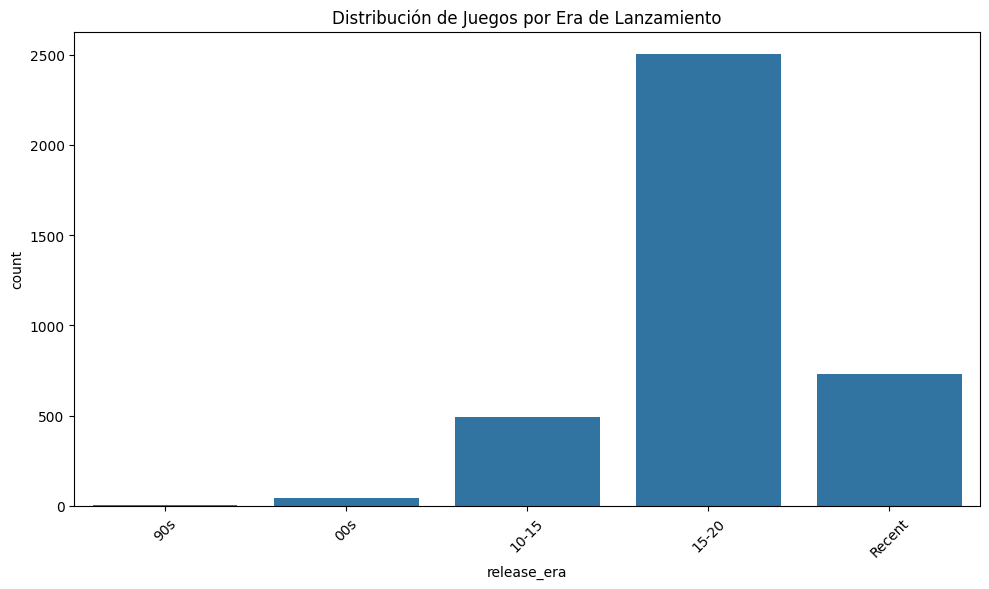

In [8]:
# Visualizar distribución de juegos por era
plt.figure(figsize=(10, 6))
sns.countplot(x='release_era', data=df)
plt.title('Distribución de Juegos por Era de Lanzamiento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Extracción de Características de Texto

In [9]:
import re

In [10]:
# Función para extraer palabras clave del nombre
def extract_keywords(name):
    if not isinstance(name, str):
        return []
    # Convertir a minúsculas y eliminar caracteres especiales
    name = re.sub(r'[^\w\s]', ' ', name.lower())
    # Dividir en palabras
    words = name.split()
    # Eliminar palabras comunes (stopwords)
    stopwords = ['the', 'of', 'and', 'in', 'a', 'to', 'for', 'with', 'on', 'at']
    keywords = [word for word in words if word not in stopwords and len(word) > 2]
    return keywords

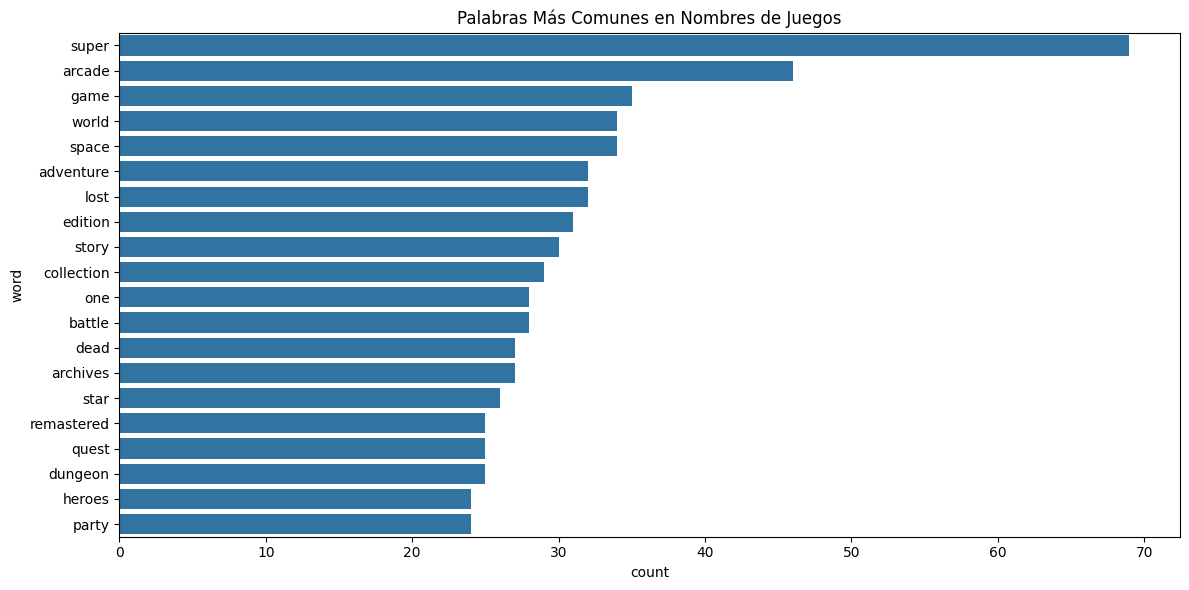

In [11]:
# Aplicar extracción de palabras clave
df['name_keywords'] = df['name'].apply(extract_keywords)

# Contar palabras más comunes
all_keywords = [word for keywords in df['name_keywords'] for word in keywords]
keyword_counts = Counter(all_keywords)

# Visualizar palabras más comunes
plt.figure(figsize=(12, 6))
common_words = pd.DataFrame(keyword_counts.most_common(20), columns=['word', 'count'])
sns.barplot(x='count', y='word', data=common_words)
plt.title('Palabras Más Comunes en Nombres de Juegos')
plt.tight_layout()
plt.show()

In [12]:
# Crear variables dummy para palabras clave comunes
for word, count in keyword_counts.most_common(10):
    df[f'has_{word}'] = df['name_keywords'].apply(lambda x: 1 if word in x else 0)

# Análisis de Componentes Principales (PCA)

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [14]:
# Seleccionar variables numéricas
numeric_features = ['playtime_log', 'metacritic', 'ratings_count', 'added',
                    'suggestions_count', 'reviews_count']
X_numeric = df[numeric_features].copy()

# Estandarizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Aplicar PCA
pca = PCA(n_components=0.95)  # Conservar el 95% de la varianza
X_pca = pca.fit_transform(X_scaled)

### Crear Dataframe

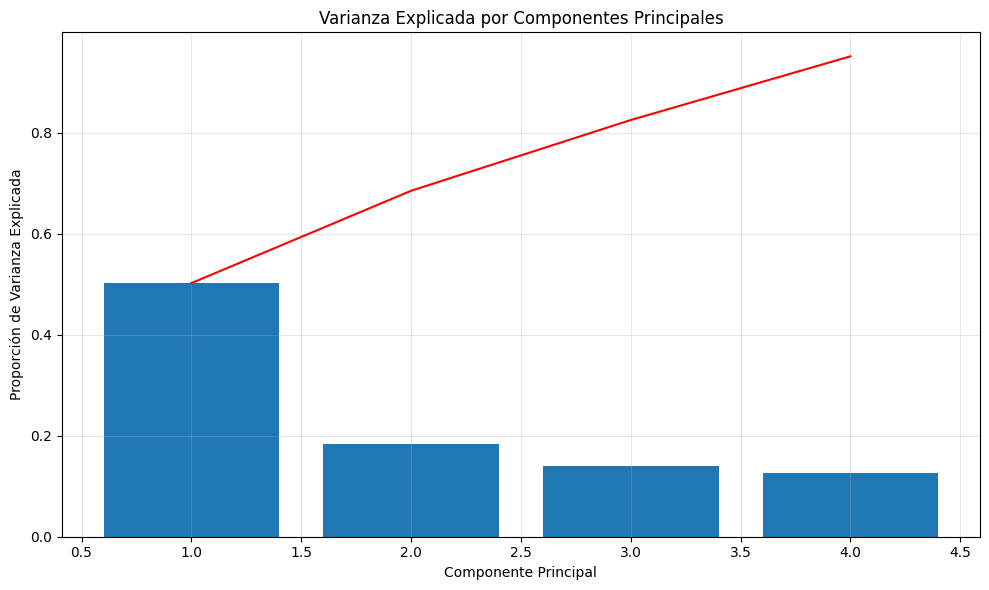

Número de componentes: 4
Varianza explicada total: 0.9517


In [15]:
# Crear DataFrame con componentes principales
pca_cols = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pca_cols)

# Añadir componentes al DataFrame original
for col in pca_cols:
    df[col] = df_pca[col].values

# Visualizar varianza explicada
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), 'r-')
plt.xlabel('Componente Principal')
plt.ylabel('Proporción de Varianza Explicada')
plt.title('Varianza Explicada por Componentes Principales')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Número de componentes: {len(pca_cols)}")
print(f"Varianza explicada total: {np.sum(pca.explained_variance_ratio_):.4f}")

 # Crear variables de interacción entre características importantes

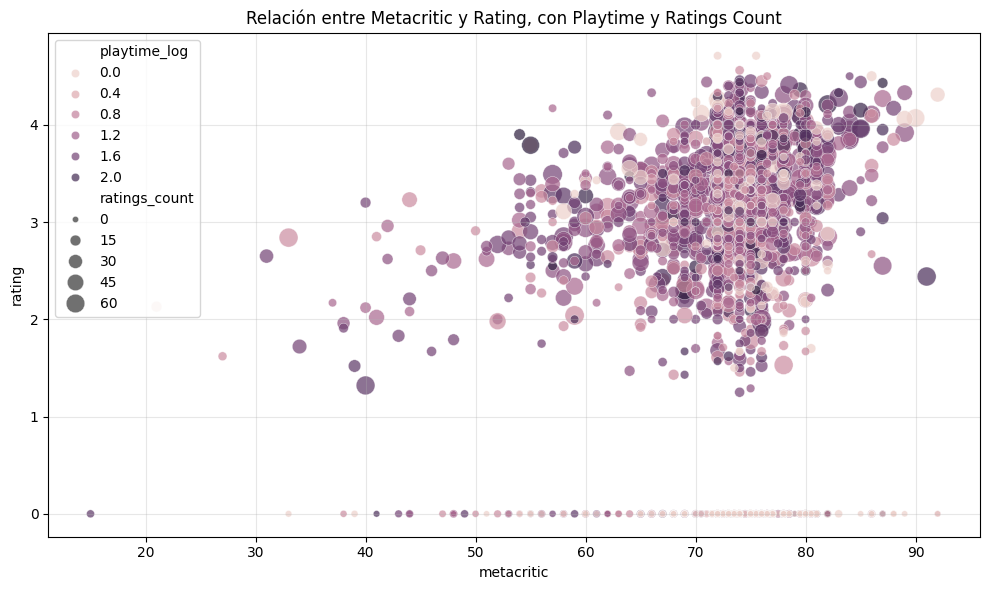

In [16]:
# Interacción entre metacritic y playtime
df['metacritic_playtime'] = df['metacritic'] * df['playtime_log']

# Interacción entre año de lanzamiento y metacritic
df['year_metacritic'] = (df['release_year'] - 2000) * df['metacritic']

# Interacción entre género y metacritic
for genre in df['main_genre'].unique():
    col_name = f'main_genre_{genre}'
    if col_name in df.columns:
        df[f'{col_name}_metacritic'] = df[col_name] * df['metacritic']

# Visualizar algunas interacciones
plt.figure(figsize=(10, 6))
sns.scatterplot(x='metacritic', y='rating', hue='playtime_log',
                size='ratings_count', sizes=(20, 200), alpha=0.7, data=df)
plt.title('Relación entre Metacritic y Rating, con Playtime y Ratings Count')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Detección y Tratamiento de Outliers con IQR

In [17]:
def detect_and_handle_outliers(df, column, method='cap'):
    """
    Detecta y maneja outliers usando el método IQR.

    Args:
        df: DataFrame
        column: Columna a procesar
        method: 'cap' para recortar, 'remove' para eliminar

    Returns:
        DataFrame procesado
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Outliers en {column}: {len(outliers)} ({len(outliers)/len(df):.2%})")

    if method == 'cap':
        # Recortar valores extremos
        df_processed = df.copy()
        df_processed[column] = df_processed[column].clip(lower_bound, upper_bound)
        return df_processed
    elif method == 'remove':
        # Eliminar outliers
        df_processed = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        return df_processed
    else:
        raise ValueError("Método no válido. Use 'cap' o 'remove'.")

# Aplicar a columnas numéricas relevantes

In [18]:
numeric_cols = ['playtime', 'metacritic', 'ratings_count', 'added']

Outliers en playtime: 30 (0.80%)


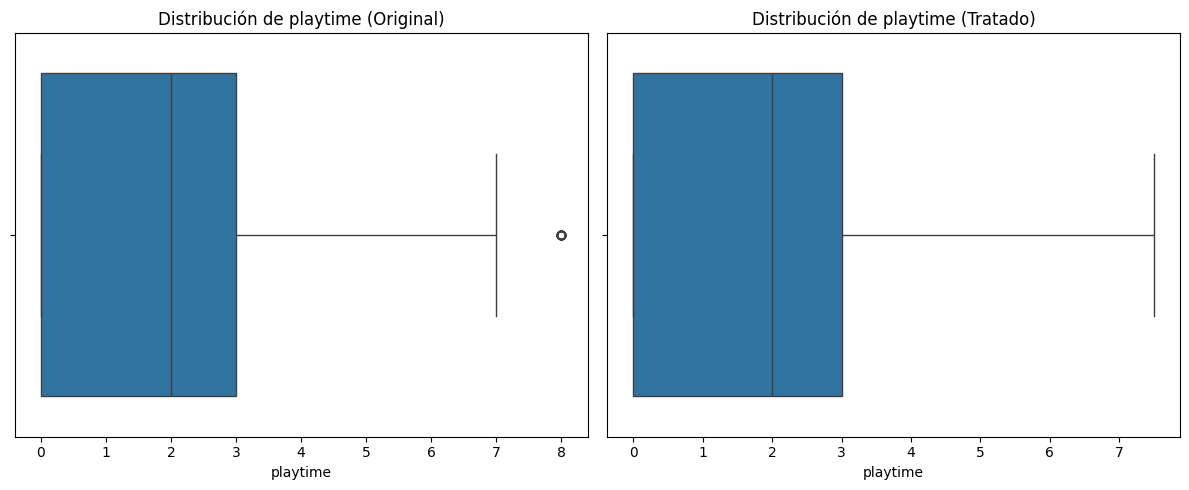

Outliers en metacritic: 309 (8.20%)


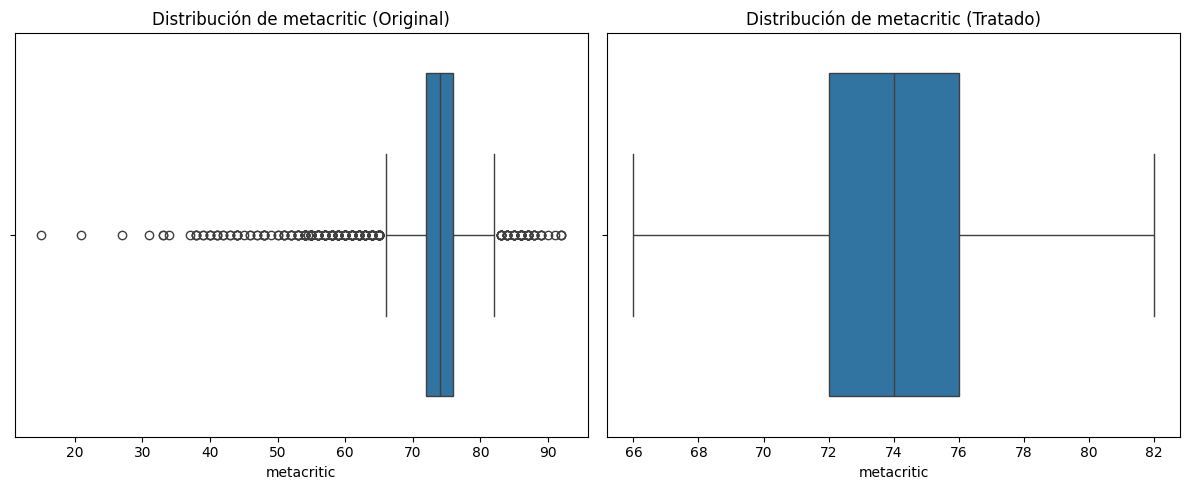

Outliers en ratings_count: 330 (8.76%)


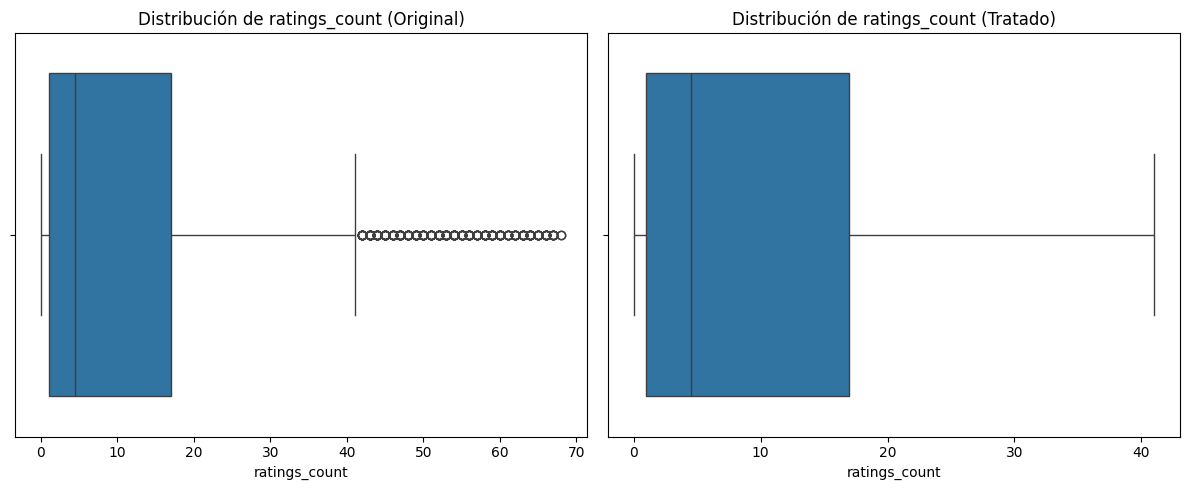

Outliers en added: 380 (10.08%)


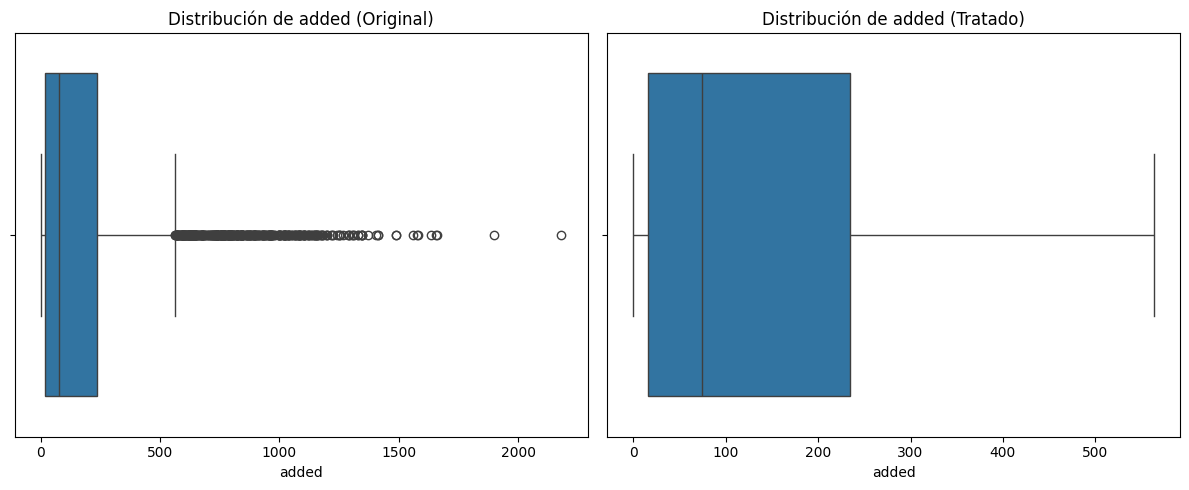

In [19]:
for col in numeric_cols:
    # Visualizar antes del tratamiento
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[col])
    plt.title(f'Distribución de {col} (Original)')

    # Tratar outliers
    df = detect_and_handle_outliers(df, col, method='cap')

    # Visualizar después del tratamiento
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.title(f'Distribución de {col} (Tratado)')

    plt.tight_layout()
    plt.show()

# Ingeniería de Características Basada en Agrupaciones

In [20]:
# Estadísticas por género
genre_stats = df.groupby('main_genre').agg({
    'rating': ['mean', 'median', 'std'],
    'metacritic': ['mean', 'median', 'std'],
    'playtime': ['mean', 'median']
})

# Aplanar columnas multinivel
genre_stats.columns = ['_'.join(col).strip() for col in genre_stats.columns.values]
genre_stats = genre_stats.reset_index()

# Unir estadísticas al DataFrame original
df = df.merge(genre_stats, on='main_genre', how='left', suffixes=('', '_genre_avg'))

# Crear características de desviación respecto a la media del género
df['rating_vs_genre_avg'] = df['rating'] - df['rating_mean']
df['metacritic_vs_genre_avg'] = df['metacritic'] - df['metacritic_mean']
df['playtime_vs_genre_avg'] = df['playtime'] - df['playtime_mean']

# Visualizar distribución de desviaciones

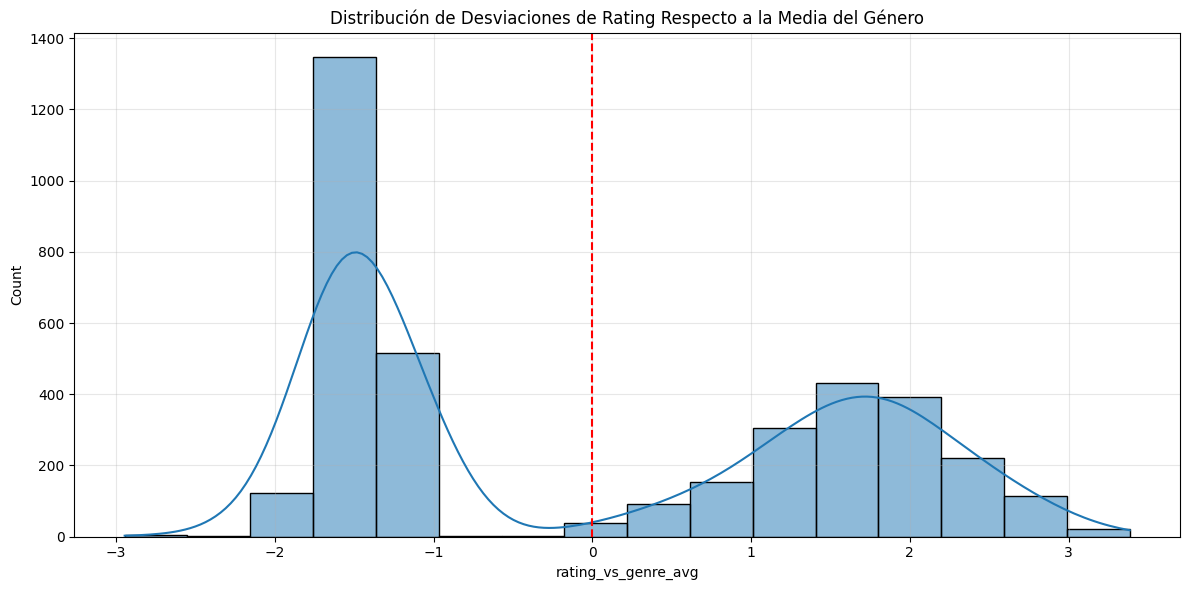

In [21]:
plt.figure(figsize=(12, 6))
sns.histplot(df['rating_vs_genre_avg'], kde=True)
plt.title('Distribución de Desviaciones de Rating Respecto a la Media del Género')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Validcacion cruzada de caracteristicas

In [22]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

In [24]:
# Preparar datos
X = df.drop(['rating', 'slug', 'name', 'released', 'updated'], axis=1)
y = df['rating']

In [30]:
# Verificar columnas categóricas restantes
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
print("Columnas categóricas restantes:", categorical_columns.tolist())

Columnas categóricas restantes: ['main_genre', 'metacritic_category', 'release_era', 'name_keywords']


In [31]:
# Codificar correctamente las columnas categóricas
# Opción 1: Eliminar columnas categóricas si no son necesarias
X = X.select_dtypes(exclude=['object', 'category'])

# Opción 2: Codificar correctamente usando get_dummies
# Primero, asegúrate de que no hay columnas con listas
for col in X.columns:
    if X[col].dtype == 'object':
        # Verificar si la columna contiene listas
        if X[col].apply(lambda x: isinstance(x, list)).any():
            print(f"La columna {col} contiene listas y debe ser procesada o eliminada")
            X = X.drop(columns=[col])
        else:
            # Si no contiene listas, podemos aplicar get_dummies
            X = pd.get_dummies(X, columns=[col], drop_first=True)

In [32]:
numeric_X = X.select_dtypes(include=['int64', 'float64', 'int32', 'float32'])

# 2. Verificar si hay columnas faltantes importantes
missing_cols = set(X.columns) - set(numeric_X.columns)
if missing_cols:
    print(f"Columnas no numéricas que serán excluidas: {missing_cols}")

In [33]:
base_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [34]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
rfecv = RFECV(
    estimator=base_model,
    step=1,
    cv=cv,
    scoring='r2',
    min_features_to_select=5,
    n_jobs=-1
)

In [35]:
# Ajustar selector
rfecv.fit(X, y)

RFECV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
      estimator=RandomForestRegressor(random_state=42),
      min_features_to_select=5, n_jobs=-1, scoring='r2')

In [37]:
selected_features = numeric_X.columns[rfecv.support_]
print(f"Número óptimo de características: {rfecv.n_features_}")
print("Características seleccionadas:")
print(selected_features.tolist())

Número óptimo de características: 5
Características seleccionadas:
['rating_top', 'ratings_count_log', 'rating_mean', 'rating_median', 'rating_vs_genre_avg']


# Creación de un Pipeline de Preprocesamiento

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [39]:
numeric_features = ['playtime', 'metacritic', 'ratings_count', 'added', 'suggestions_count']
categorical_features = ['main_genre', 'metacritic_category']
date_features = ['released']

# Preprocesador para variables numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [40]:
# Preprocesador para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combinar preprocesadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Descartar columnas no especificadas
)

In [41]:
# Crear pipeline completo con preprocesamiento y modelo
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [42]:
from sklearn.model_selection import train_test_split
X = df.drop('rating', axis=1)
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Ajustar pipeline
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['playtime', 'metacritic',
                                                   'ratings_count', 'added',
                                                   'suggestions_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['main_genre',
                                                   'metacritic_category'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [50]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score

In [51]:
# Evaluar
y_pred = full_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

MSE: 0.2178
R²: 0.9199
